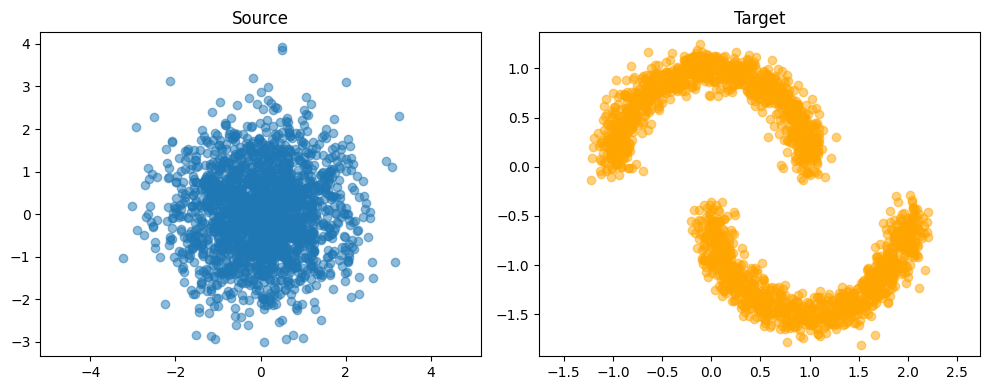

In [111]:
# 1. Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchdiffeq import odeint
import random
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(42)

# 2. Data Generation (shared)

def sample_standard_gaussian(n_samples=1000):
    return np.random.randn(n_samples, 2).astype(np.float32)

def sample_swiss_roll(n_samples=1000):
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(n_samples))
    x = t * np.cos(t)
    y = t * np.sin(t)
    noise = 0.5 * np.random.randn(n_samples)
    return np.stack([x, y + noise], axis=1).astype(np.float32)

def sample_star_distribution(n_samples=1000, arms=5):
    angles = np.random.choice(np.linspace(0, 2*np.pi, arms, endpoint=False), n_samples)
    r = 2 + 0.3 * np.random.randn(n_samples)
    x = r * np.cos(angles) + 0.1 * np.random.randn(n_samples)
    y = r * np.sin(angles) + 0.1 * np.random.randn(n_samples)
    return np.stack([x, y], axis=1).astype(np.float32)

def sample_gaussian_mixture(n_samples=1000):
    centers = [np.array([-2.0, 0.0]), np.array([2.0, 0.0])]
    samples = []
    for _ in range(n_samples):
        center = centers[np.random.choice([0, 1])]
        noise = np.random.randn(2) * 0.2
        samples.append(center + noise)
    return np.array(samples, dtype=np.float32)

def sample_flower_distribution(n_samples=1000, petals=6):
    theta = 2 * np.pi * np.random.rand(n_samples)
    r = 2.0 + 0.3 * np.sin(petals * theta) + 0.1 * np.random.randn(n_samples)
    x = r * np.cos(theta) + 0.05 * np.random.randn(n_samples)
    y = r * np.sin(theta) + 0.05 * np.random.randn(n_samples)
    return np.stack([x, y], axis=1).astype(np.float32)

def sample_two_moons(n_samples=1000, noise=0.1):
    n_half = n_samples // 2
    # upper moon
    theta1 = np.linspace(0, np.pi, n_half)
    x1 = np.cos(theta1)
    y1 = np.sin(theta1)
    # lower moon
    theta2 = np.linspace(0, np.pi, n_samples - n_half)
    x2 = 1 - np.cos(theta2)
    y2 = -np.sin(theta2) - 0.5
    # combine and add some noise
    x = np.concatenate([x1, x2]) + noise * np.random.randn(n_samples)
    y = np.concatenate([y1, y2]) + noise * np.random.randn(n_samples)
    return np.stack([x, y], axis=1).astype(np.float32)

def sample_8gaussians(n_samples=1000):
    angles = np.linspace(0, 2 * np.pi, 9)[:-1]  # 8个方向
    centers = np.stack([np.cos(angles), np.sin(angles)], axis=1) * 2
    data = []
    for i in range(n_samples):
        center = centers[np.random.randint(8)]
        point = center + 0.1 * np.random.randn(2)
        data.append(point)
    return np.array(data, dtype=np.float32)

def sample_checkerboard(n_samples=1000):

    x1 = np.random.rand(n_samples) * 4 - 2  # [-2, 2]
    x2_base = np.random.rand(n_samples) + np.floor(x1) % 2  # shift
    x2 = x2_base + np.random.randint(0, 2, size=n_samples) * 2  # make it jump
    x2 = x2 % 4 - 2  # wrap to [-2, 2]
    return np.stack([x1, x2], axis=1).astype(np.float32)

source_np = sample_standard_gaussian(2000)
target_np = sample_two_moons(2000)
# target_np = sample_swiss_roll(2000)
# target_np = sample_gaussian_mixture(1000)
# source_np = sample_swiss_roll(1000)
# target_np = sample_standard_gaussian(1000)
# target_np = sample_8gaussians(2000)
# target_np = sample_
# board(2000)

# Visualize source and target samples
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(source_np[:, 0], source_np[:, 1], alpha=0.5)
plt.title("Source")
plt.axis("equal")

plt.subplot(1, 2, 2)
plt.scatter(target_np[:, 0], target_np[:, 1], alpha=0.5, color='orange')
plt.title("Target")
plt.axis("equal")

plt.tight_layout()
plt.show()

In [112]:
# Re-import after kernel reset
from scipy.linalg import sqrtm
from scipy.stats import wasserstein_distance

# Redefine metrics
def frechet_distance(X_gen, X_real):
    mu_gen = np.mean(X_gen, axis=0)
    mu_real = np.mean(X_real, axis=0)
    cov_gen = np.cov(X_gen, rowvar=False)
    cov_real = np.cov(X_real, rowvar=False)
    covmean = sqrtm(cov_gen @ cov_real)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    diff = mu_gen - mu_real
    return diff @ diff + np.trace(cov_gen + cov_real - 2 * covmean)

def wasserstein_2d(X_gen, X_real):
    d1 = wasserstein_distance(X_gen[:, 0], X_real[:, 0])
    d2 = wasserstein_distance(X_gen[:, 1], X_real[:, 1])
    return (d1 + d2) / 2


In [113]:
# Convert to Torch tensors
source_data = torch.tensor(source_np)
target_data = torch.tensor(target_np)
dataset = TensorDataset(source_data, target_data)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)


In [114]:
# 4. CNF (ODE-based Flow)
class CNFNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, x):
        t_expand = t.expand_as(x[:, :1])
        xt = torch.cat([x, t_expand], dim=1)
        return self.net(xt)

# 6. CNF Training (Log-likelihood Based)

# Helper: log probability of standard Gaussian

def standard_normal_logprob(z):
    return -0.5 * (z.pow(2) + np.log(2 * np.pi)).sum(dim=1)

# CNF with Hutchinson trace estimation
def trace_df_dx(f, x, t):
    e = torch.randn_like(x)  # random vector for Hutchinson estimator
    e_dz = torch.autograd.grad(f(t, x), x, e, create_graph=True)[0]
    return (e_dz * e).sum(dim=1)

def train_cnf(model, data, epochs=100, lr=1e-3, batch_size=256, method="rk4"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    num_samples = data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        perm = torch.randperm(num_samples)
        for i in range(num_batches):
            idx = perm[i * batch_size: (i + 1) * batch_size]
            x_T = data[idx].clone().detach().requires_grad_(True)
            logp_T = torch.zeros(x_T.shape[0], device=x_T.device)

            def odefunc(t, state):
                x, logp = state
                dx = model(t, x)
                dlogp = -trace_df_dx(model, x, t)
                return dx, dlogp

            t_vals = torch.tensor([1.0, 0.0], device=x_T.device)
            (z_0, delta_logp) = odeint(odefunc, (x_T, logp_T), t_vals, method=method, options={"step_size": 0.1}, atol=1e-5, rtol=1e-5)

            logp_0 = standard_normal_logprob(z_0[-1])
            logp_x = logp_0 - delta_logp[-1]
            loss = -logp_x.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"[CNF] Epoch {epoch} | NLL: {loss.item():.4f}")

# 7. Visualization
def sample_from_cnf(model, n_samples=1000):
    model.eval()
    with torch.no_grad():
        z0 = torch.randn(n_samples, 2)

        def odefunc(t, x):
            return model(t, x)

        t0, t1 = 0.0, 1.0
        t_vals = torch.tensor([t0, t1], dtype=z0.dtype, device=z0.device)
        out = odeint(odefunc, z0, t_vals)
        xT = out[1]  # take the final result
        return xT

def visualize_cnf(model, source_data, t_vals=None, target_np=None, save_path = "cnf_trajectory.png"):
    """
    Visualize CNF trajectories and generated samples.
    Args:
        model: trained CNF model
        source_data: Tensor of source samples (fixed, given)
        t_vals: time steps (optional)
        target_np: target distribution samples (numpy array)
    """
    device = next(model.parameters()).device
    model.eval()

    if t_vals is None:
        t_vals = torch.linspace(0, 1, 20).to(device)

    x0 = source_data.to(device)

    with torch.no_grad():
        cnf_trajectory = odeint(model, x0, t_vals)

    cnf_generated = cnf_trajectory[-1].cpu().numpy()

    fig, axes = plt.subplots(1, len(t_vals)//4 + 1, figsize=(18, 3))
    for i, t_idx in enumerate(range(0, len(t_vals), 4)):
        axes[i].scatter(cnf_trajectory[t_idx][:, 0].cpu(), cnf_trajectory[t_idx][:, 1].cpu(), alpha=0.4, color='orange')
        axes[i].set_title(f"CNF t={t_vals[t_idx]:.2f}")

    axes[-1].scatter(target_np[:, 0], target_np[:, 1], alpha=0.3, label="Target")
    axes[-1].scatter(cnf_generated[:, 0], cnf_generated[:, 1], alpha=0.3, label="CNF", color='orange')
    axes[-1].legend()
    axes[-1].set_title("CNF Gen vs Target")
    plt.tight_layout()
    plt.savefig(save_path, dpi = 300)
    plt.show()

    fd_cnf = frechet_distance(cnf_generated, target_np)
    wd_cnf = wasserstein_2d(cnf_generated, target_np)
    print('The frechet distance of CNF model is: ', fd_cnf)
    print('The wasserstein distance of CNF model is: ', wd_cnf)


In [115]:
# 8. CNF to RF Student Reflow Training

# Define the RF student model (simple MLP for velocity prediction)
class RFStudent(nn.Module):
    def __init__(self, dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, t, x):
        if len(t.shape) == 0:  # scalar t
            t = t.expand(x.shape[0], 1)
        elif len(t.shape) == 1:
            t = t.unsqueeze(1)
        tx = torch.cat([t, x], dim=1)
        return self.net(tx)

# Train RF student model using CNF teacher trajectories
def train_rf_student(cnf_teacher, source_data, epochs=100, batch_size=256, num_steps=20, lr=1e-3):
    """
    Train a RF Student model using fixed source data.
    Args:
        cnf_teacher: teacher CNF model
        source_data: Tensor of fixed source samples
        epochs: number of training epochs
        batch_size: mini-batch size
        num_steps: trajectory steps
        lr: learning rate
    Returns:
        Trained student model
    """
    device = next(cnf_teacher.parameters()).device
    cnf_teacher.eval()

    z0 = source_data.to(device)
    t_vals = torch.linspace(0.0, 1.0, num_steps).to(device)

    # Generate trajectory
    with torch.no_grad():
        trajectory = odeint(cnf_teacher, z0, t_vals, method="rk4")

    # Build training dataset (t, x, v)
    t_samples = []
    x_samples = []
    v_samples = []

    for i in range(num_steps):
        t_i = t_vals[i]
        x_i = trajectory[i]
        with torch.no_grad():
            v_i = cnf_teacher(t_i, x_i)

        t_samples.append(t_i.expand(x_i.shape[0]))
        x_samples.append(x_i)
        v_samples.append(v_i)

    t_train = torch.cat(t_samples, dim=0)
    x_train = torch.cat(x_samples, dim=0)
    v_train = torch.cat(v_samples, dim=0)

    # Train Student
    student = RFStudent().to(device)
    optimizer = torch.optim.Adam(student.parameters(), lr=lr)

    num_data = t_train.shape[0]
    num_batches = (num_data + batch_size - 1) // batch_size

    for epoch in range(epochs):
        perm = torch.randperm(num_data)
        for i in range(num_batches):
            idx = perm[i * batch_size: (i + 1) * batch_size]
            t_batch = t_train[idx]
            x_batch = x_train[idx]
            v_batch = v_train[idx]

            pred_v = student(t_batch, x_batch)
            loss = ((pred_v - v_batch) ** 2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f"[RF-Student] Epoch {epoch} | Loss: {loss.item():.4f}")

    return student,trajectory


def visualize_rf_student(student_model, source_data, n_steps=20, dt=1.0/20, target_np=None, save_path = "rf_student_trajectory.png"):
    """
    Visualize RF Student model's trajectory and final generation.
    Args:
        student_model: trained RF Student model
        source_data: Tensor of fixed source samples
        n_steps: number of Euler steps
        dt: step size
        target_np: numpy array of target samples
    """
    device = next(student_model.parameters()).device
    student_model.eval()

    z = source_data.to(device)
    trajectory = [z.detach().cpu().numpy()]
    t = torch.zeros(z.shape[0], 1).to(device)

    for step in range(n_steps):
        v = student_model(t.squeeze(1), z)
        z = z + dt * v
        t += dt
        trajectory.append(z.detach().cpu().numpy())

    fig, axes = plt.subplots(1, len(trajectory)//4 + 1, figsize=(18, 3))
    for i, idx in enumerate(range(0, len(trajectory), 4)):
        axes[i].scatter(trajectory[idx][:, 0], trajectory[idx][:, 1], alpha=0.4, color='orange')
        axes[i].set_title(f"RF Step {idx}")

    axes[-1].scatter(target_np[:, 0], target_np[:, 1], alpha=0.3, label="Target")
    axes[-1].scatter(trajectory[-1][:, 0], trajectory[-1][:, 1], alpha=0.3, label="RF Student", color='orange')
    axes[-1].legend()
    axes[-1].set_title("RF Gen vs Target")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

    rf_generated = trajectory[-1]
    fd_rf = frechet_distance(rf_generated, target_np)
    wd_rf = wasserstein_2d(rf_generated, target_np)
    print('The frechet distance of RF model is: ', fd_rf)
    print('The wasserstein distance of RF model is: ', wd_rf)

Training Continuous Normalizing Flow...
[CNF] Epoch 0 | NLL: 2.5263
[CNF] Epoch 10 | NLL: 2.2000
[CNF] Epoch 20 | NLL: 1.6994
[CNF] Epoch 30 | NLL: 1.4662
[CNF] Epoch 40 | NLL: 1.3413
[CNF] Epoch 50 | NLL: 1.2326
[CNF] Epoch 60 | NLL: 1.1896
[CNF] Epoch 70 | NLL: 1.0846
[CNF] Epoch 80 | NLL: 1.1474
[CNF] Epoch 90 | NLL: 1.1728
[CNF] Epoch 100 | NLL: 1.1609
[CNF] Epoch 110 | NLL: 1.2249
[CNF] Epoch 120 | NLL: 1.2001
[CNF] Epoch 130 | NLL: 1.1498
[CNF] Epoch 140 | NLL: 1.1818
[CNF] Epoch 150 | NLL: 1.1526
[CNF] Epoch 160 | NLL: 1.1143
[CNF] Epoch 170 | NLL: 1.1813
[CNF] Epoch 180 | NLL: 0.9529
[CNF] Epoch 190 | NLL: 1.0085
[CNF] Epoch 200 | NLL: 1.0061
[CNF] Epoch 210 | NLL: 0.9794
[CNF] Epoch 220 | NLL: 1.0556
[CNF] Epoch 230 | NLL: 1.0380
[CNF] Epoch 240 | NLL: 0.9666
[CNF] Epoch 250 | NLL: 1.0785
[CNF] Epoch 260 | NLL: 1.0070
[CNF] Epoch 270 | NLL: 1.0296
[CNF] Epoch 280 | NLL: 1.0180
[CNF] Epoch 290 | NLL: 1.0251
183.11430406570435


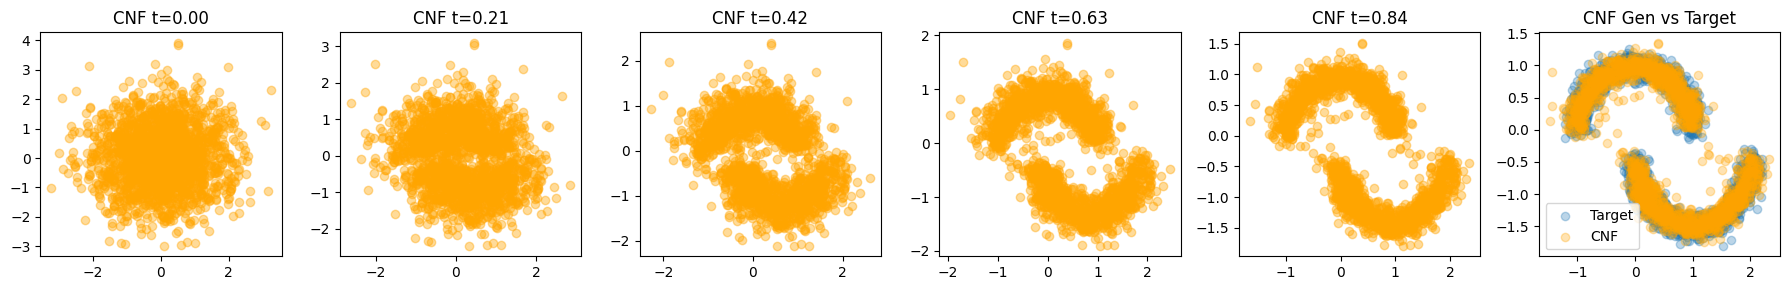

The frechet distance of CNF model is:  0.001111646387127685
The wasserstein distance of CNF model is:  0.02621476455841093


In [116]:
# 8. Main Execution
import time
import psutil
import os
import tracemalloc
import torch.cuda
if __name__ == "__main__":
    # Initialize models
    cnf_model = CNFNet()



    print("Training Continuous Normalizing Flow...")
    start_time = time.time()
    train_cnf(cnf_model, target_data, epochs= 300)
    cnf_time = time.time() - start_time
    print(cnf_time)



    # Visualize learned transformations
    visualize_cnf(cnf_model, source_data=source_data, target_np=target_np, save_path = "cnf_trajectory_2Moon.png")






===== Starting Reflow Round 1 =====
[RF-Student] Epoch 0 | Loss: 0.2875
[RF-Student] Epoch 10 | Loss: 0.0086
[RF-Student] Epoch 20 | Loss: 0.0007
[RF-Student] Epoch 30 | Loss: 0.0003
[RF-Student] Epoch 40 | Loss: 0.0003
[RF-Student] Epoch 50 | Loss: 0.0001
[RF-Student] Epoch 60 | Loss: 0.0001
[RF-Student] Epoch 70 | Loss: 0.0000
[RF-Student] Epoch 80 | Loss: 0.0000
[RF-Student] Epoch 90 | Loss: 0.0000
[RF-Student] Epoch 100 | Loss: 0.0000
[RF-Student] Epoch 110 | Loss: 0.0000
[RF-Student] Epoch 120 | Loss: 0.0000
[RF-Student] Epoch 130 | Loss: 0.0000
[RF-Student] Epoch 140 | Loss: 0.0000
[RF-Student] Epoch 150 | Loss: 0.0000
[RF-Student] Epoch 160 | Loss: 0.0000
[RF-Student] Epoch 170 | Loss: 0.0000
[RF-Student] Epoch 180 | Loss: 0.0000
[RF-Student] Epoch 190 | Loss: 0.0000
[RF-Student] Epoch 200 | Loss: 0.0000
[RF-Student] Epoch 210 | Loss: 0.0000
[RF-Student] Epoch 220 | Loss: 0.0000
[RF-Student] Epoch 230 | Loss: 0.0000
[RF-Student] Epoch 240 | Loss: 0.0000
[RF-Student] Epoch 250 |

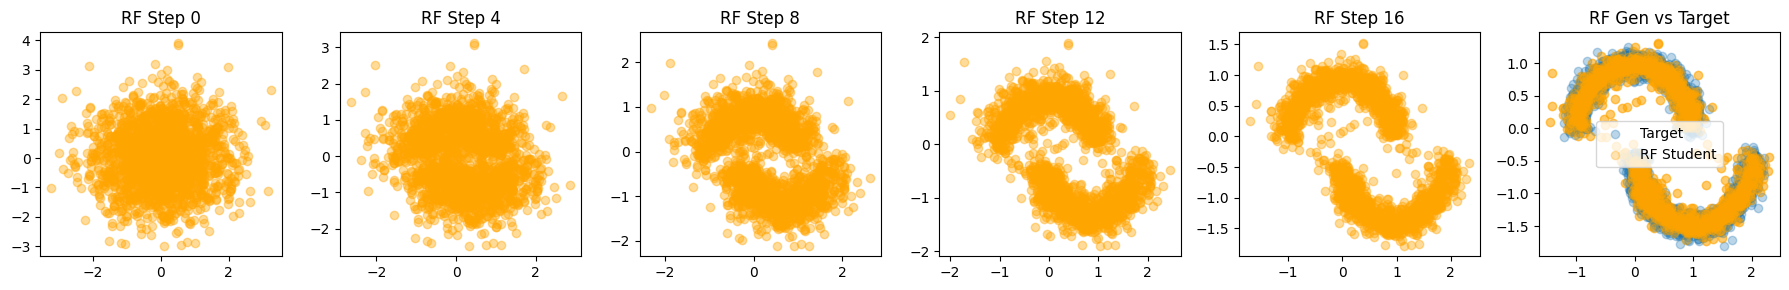

The frechet distance of RF model is:  0.0007484394698029639
The wasserstein distance of RF model is:  0.02467993445613592


In [117]:
teacher = cnf_model
for round_idx in range(1):  # 3 rounds of Reflow
    print(f"\n===== Starting Reflow Round {round_idx+1} =====")
    student,trajectory = train_rf_student(teacher, source_data = source_data, epochs=400, batch_size = 256, lr = 1e-4, num_steps = 50)
    visualize_rf_student(student, source_data = source_data, target_np=target_np, save_path="rf_student_trajectory_2Moon.png")  # Optional: visualize after each round
    teacher = student  # Update teacher


In [118]:
# High-precision timing utility for CUDA
def measure_inference_time(model_fn, source_data, repeat=5):
    torch.cuda.synchronize()
    start = time.perf_counter()

    for _ in range(repeat):
        model_fn(source_data)

    torch.cuda.synchronize()
    end = time.perf_counter()

    avg_time = (end - start) / repeat
    return avg_time

# CNF inference function
def cnf_inference(source_data):
    with torch.no_grad():
        t_vals = torch.linspace(0, 1, 20).to(source_data.device)  # Ensure time steps are on the same device
        _ = odeint(cnf_model, source_data, t_vals)

# RF student inference function
def rf_student_inference(source_data):
    with torch.no_grad():
        z = source_data.to(device)
        t = torch.zeros(z.size(0), 1).to(device)
        dt = 1.0 / 20
        for _ in range(20):  # Fixed number of Euler steps
            v = rf_student_model(t.squeeze(1), z)
            z = z + dt * v
            t += dt

# Setup for timing comparison
batch_size = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
rf_student_model = teacher

# Move models to the target device (important!)
cnf_model = cnf_model.to(device)
rf_student_model = rf_student_model.to(device)

# Generate random source inputs
source_data = torch.randn(batch_size, 2).to(device)

# Measure average inference time
cnf_time = measure_inference_time(cnf_inference, source_data)
rf_time = measure_inference_time(rf_student_inference, source_data)

print(f"Average CNF inference time: {cnf_time * 1000:.2f} ms")
print(f"Average RF Student inference time: {rf_time * 1000:.2f} ms")

Average CNF inference time: 169.73 ms
Average RF Student inference time: 6.74 ms


In [119]:
def compute_log_likelihood_cnf(model, data, batch_size, log_p0_fn=standard_normal_logprob,
                               atol=1e-5, rtol=1e-5, method="rk4", step_size=0.1):
    """
    Compute the mean NLL (Negative Log-Likelihood) over the dataset using CNF model with batching.

    Args:
        model: Trained CNF model.
        data: Dataset (torch.Tensor), shape [num_samples, ...].
        batch_size: Batch size for processing.
        log_p0_fn: Base distribution log-probability function (default: standard normal).
        atol: Absolute tolerance for ODE solver.
        rtol: Relative tolerance for ODE solver.
        method: ODE solver method (e.g., "rk4", "dopri5").
        step_size: Fixed step size for ODE solver (if supported).

    Returns:
        mean_nll: The mean Negative Log-Likelihood over the dataset.
    """
    model.eval()
    num_samples = data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    all_nll = []

    for i in range(num_batches):
        x_batch = data[i * batch_size: (i + 1) * batch_size].to(device)
        logp_T = torch.zeros(x_batch.shape[0], device=x_batch.device)

        def odefunc(t, state):
            x, logp = state
            x.requires_grad_(True)
            dx = model(t, x)
            dlogp = -trace_df_dx(model, x, t)
            return dx, dlogp
        t_vals = torch.tensor([1.0, 0.0], device=x_batch.device)
        (z0, delta_logp) = odeint(
            odefunc, (x_batch, logp_T), t_vals,
            atol=atol, rtol=rtol, method=method,
            options={"step_size": step_size}
        )
        log_p0 = log_p0_fn(z0[-1])
        log_p1 = log_p0 - delta_logp[-1]
        nll_batch = -log_p1  # Negative Log-Likelihood
        all_nll.append(nll_batch.cpu())

    all_nll = torch.cat(all_nll, dim=0)
    mean_nll = all_nll.mean().item()
    return mean_nll

In [120]:
mean_nll = compute_log_likelihood_cnf(cnf_model, target_data, batch_size=128)
print(f"Dataset Mean NLL: {mean_nll:.4f}")



Dataset Mean NLL: 1.0565


In [121]:
def compute_log_likelihood_fm(fm_model, data, batch_size=128,
                                           log_p0_fn=standard_normal_logprob,
                                           atol=1e-5, rtol=1e-5, method="rk4",
                                           step_size=0.1):
    """
    Compute Mean NLL for FM model using ODE Solver with batch processing.

    Args:
        fm_model: Trained FM model.
        data: Dataset (torch.Tensor), shape [num_samples, ...], this is x1.
        batch_size: Batch size for memory-efficient computation.
        log_p0_fn: Base distribution log-probability function.
        atol, rtol, method, step_size: ODE solver configurations.

    Returns:
        mean_nll: Mean Negative Log-Likelihood over the dataset.
    """
    device = data.device
    fm_model = fm_model.to(device)
    fm_model.eval()
    num_samples = data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    all_nll = []

    for i in range(num_batches):
        x_batch = data[i * batch_size: (i + 1) * batch_size].to(device)
        logp_T = torch.zeros(x_batch.shape[0], device=device)

        def odefunc(t, state):
            x, logp = state
            x.requires_grad_(True)
            dx = fm_model(t, x)
            dlogp = -trace_df_dx(fm_model, x, t)
            return dx, dlogp

        t_vals = torch.tensor([1.0, 0.0], device=device)  # Reverse integration

        (z0, delta_logp) = odeint(
            odefunc, (x_batch, logp_T), t_vals,
            atol=atol, rtol=rtol, method=method,
            options={"step_size": step_size}
        )

        log_p0 = log_p0_fn(z0[-1])  # [batch_size]
        log_p1 = log_p0 - delta_logp[-1]  # [batch_size]
        # print(log_p0)
        nll_batch = -log_p1  # NLL per sample
        all_nll.append(nll_batch.cpu())

    all_nll = torch.cat(all_nll, dim=0)  # [num_samples]
    mean_nll = all_nll.mean().item()  # Final Mean NLL

    return mean_nll


In [122]:
mean_nll_fm = compute_log_likelihood_fm(
    fm_model=student,
    data=target_data.to(device),
    batch_size=128
)
print(f"FM Mean NLL (with ODE Solver): {mean_nll_fm:.4f}")

FM Mean NLL (with ODE Solver): 1.0478


In [123]:
# 3. Rectified Flow (RF) Network
class RFNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, x):
        t_expand = t.expand_as(x[:, :1])
        xt = torch.cat([x, t_expand], dim=1)
        return self.net(xt)
# 5. RF Training

def train_rf(model, dataloader, epochs=1000, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.train()

    for epoch in range(epochs):
        for x0, x1 in dataloader:
            t = torch.rand(x0.size(0), 1)
            xt = (1 - t) * x0 + t * x1
            v_target = x1 - x0
            v_pred = model(t, xt)
            loss = loss_fn(v_pred, v_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 50 == 0:
            print(f"[RF] Epoch {epoch} | Loss: {loss.item():.4f}")
            
def visualize_rf(rf_model, source_data, n_steps=20, dt=1.0/20, target_np=None, save_path="FM(RF based)_trajectory.png"):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    device = next(rf_model.parameters()).device
    rf_model.eval()

    z = source_data.to(device)
    trajectory = [z.detach().cpu().numpy()]
    t = torch.zeros(z.shape[0], 1).to(device)

    for step in range(n_steps):
        v = rf_model(t, z)
        z = z + dt * v
        t += dt
        trajectory.append(z.detach().cpu().numpy())

    # 🔧 修复：创建子图
    num_plots = len(trajectory) // 4 + 1
    fig, axes = plt.subplots(1, num_plots, figsize=(18, 3))
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    # 可视化每一步
    for i, idx in enumerate(range(0, len(trajectory), 4)):
        t_val = idx * dt
        axes[i].scatter(trajectory[idx][:, 0], trajectory[idx][:, 1], alpha=0.4, color='orange')
        axes[i].set_title(f"t = {t_val:.2f}")

    # 最后一张图对比生成 vs 目标
    axes[-1].scatter(target_np[:, 0], target_np[:, 1], alpha=0.3, label="Target")
    axes[-1].scatter(trajectory[-1][:, 0], trajectory[-1][:, 1], alpha=0.3, label="t = 1.00", color='orange')
    axes[-1].legend()
    axes[-1].set_title("RF Gen vs Target")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

    # 分数计算
    rf_generated = trajectory[-1]
    fd_rf = frechet_distance(rf_generated, target_np)
    wd_rf = wasserstein_2d(rf_generated, target_np)
    print('The frechet distance of RF model is: ', fd_rf)
    print('The wasserstein distance of RF model is: ', wd_rf)

[RF] Epoch 0 | Loss: 1.6735
[RF] Epoch 50 | Loss: 1.3631
[RF] Epoch 100 | Loss: 1.2285
[RF] Epoch 150 | Loss: 1.2779
[RF] Epoch 200 | Loss: 1.1245
[RF] Epoch 250 | Loss: 1.1799
[RF] Epoch 300 | Loss: 1.2291
[RF] Epoch 350 | Loss: 1.1081
[RF] Epoch 400 | Loss: 1.1800
[RF] Epoch 450 | Loss: 1.1822
[RF] Epoch 500 | Loss: 1.1200
[RF] Epoch 550 | Loss: 1.2063
[RF] Epoch 600 | Loss: 1.1219
[RF] Epoch 650 | Loss: 1.1796
[RF] Epoch 700 | Loss: 1.1750
[RF] Epoch 750 | Loss: 1.1111
[RF] Epoch 800 | Loss: 1.1898
[RF] Epoch 850 | Loss: 1.2410
[RF] Epoch 900 | Loss: 1.2654
[RF] Epoch 950 | Loss: 1.0920


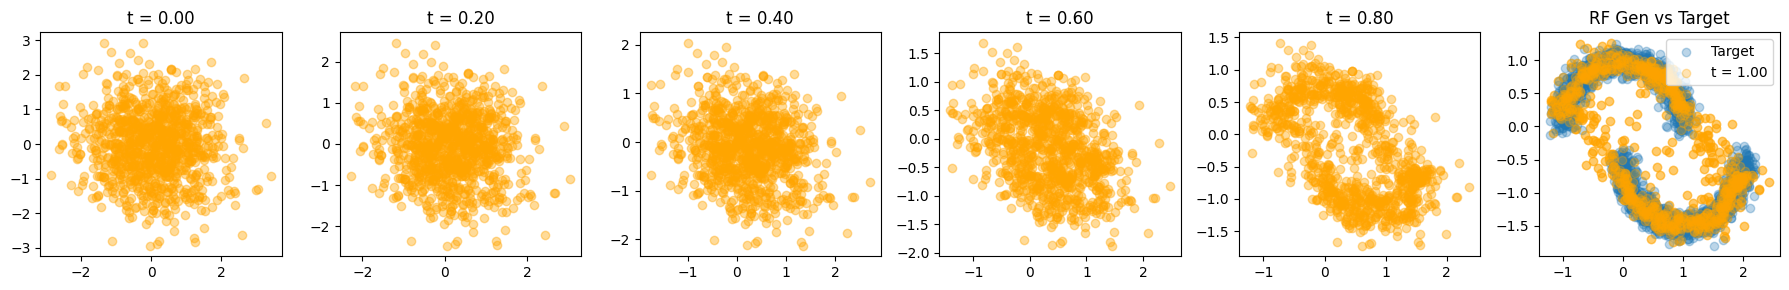

The frechet distance of RF model is:  0.006002781998568407
The wasserstein distance of RF model is:  0.05930841608855464


In [124]:
rf_model = RFNet()
train_rf(rf_model, dataloader,epochs=1000, lr=1e-3)
visualize_rf(rf_model, source_data = source_data, target_np=target_np, save_path = "FM(RF based)_trajectory_2Moon.png")

In [125]:
mean_nll_fm_only = compute_log_likelihood_fm(
    fm_model=rf_model,
    data=target_data.to(device),
    batch_size=128
)
print(f"FM based on RF (with ODE Solver): {mean_nll_fm_only:.4f}")

FM based on RF (with ODE Solver): 1.2551


In [126]:
def visualize_divergence_std_over_time(cnf_model, fm_model, rf_model, trajectory, t_vals, save_path = "divergence.png"):
    cnf_model.eval()
    fm_model.eval()
    rf_model.eval()

    device = t_vals.device  # Use the device where t_vals is

    cnf_std_list = []
    fm_std_list = []
    rf_std_list = []

    for i, t in enumerate(t_vals):
        x_t = trajectory[i].to(device).requires_grad_(True)
        t = t.to(device)

        # Compute divergence for all three models
        cnf_div = trace_df_dx(cnf_model, x_t, t)
        fm_div = trace_df_dx(fm_model, x_t, t)
        rf_div = trace_df_dx(rf_model, x_t, t)

        cnf_std_list.append(cnf_div.std().item())
        fm_std_list.append(fm_div.std().item())
        rf_std_list.append(rf_div.std().item())

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t_vals.cpu(), cnf_std_list, label="CNF Divergence STD", linestyle="-")
    plt.plot(t_vals.cpu(), fm_std_list, label="FM (Reflow) Divergence STD", linestyle="--")
    plt.plot(t_vals.cpu(), rf_std_list, label="Rectified Flow Divergence STD", linestyle=":")
    plt.xlabel("Time")
    plt.ylabel("Divergence Std (per batch)")
    plt.title("Divergence Standard Deviation over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

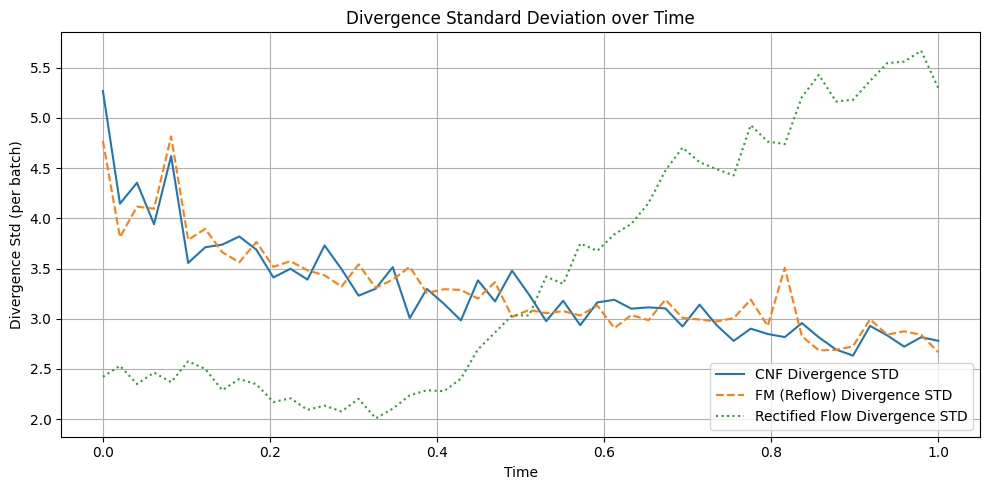

In [127]:
t_vals = torch.linspace(0, 1, 50).to(device)
visualize_divergence_std_over_time(cnf_model, student, rf_model, trajectory, t_vals, save_path = "divergence_std_over_time_2Moon.png")

In [144]:
def compute_log_density(cnf_model, x1, method="rk4"):
    x1 = x1.clone().detach().requires_grad_(True)
    logp1 = torch.zeros(x1.shape[0], device=x1.device)

    def odefunc(t, state):
        x, logp = state
        dx = cnf_model(t, x)
        dlogp = -trace_df_dx(cnf_model, x, t)
        return dx, dlogp

    t_vals = torch.tensor([1.0, 0.0], device=x1.device)
    (z0, delta_logp) = odeint(odefunc, (x1, logp1), t_vals, method=method)

    logp_z0 = standard_normal_logprob(z0[-1])
    logp_x1 = logp_z0 - delta_logp[-1]
    return logp_x1


cnf_model = cnf_model.to(device)

z0 = torch.randn(3000, 2).to(dtype=torch.float32, device=device)
t_vals = torch.tensor([0.0, 1.0], device=device)

with torch.no_grad():
    x1 = odeint(cnf_model, z0, t_vals)[-1]

logp = compute_log_density(cnf_model, x1)
print("CNF average log density:", logp.mean().item())



CNF average log density: -0.9981484413146973


In [140]:
x0 = torch.randn(3000, 2).to(device)
with torch.no_grad():
    x1_rf = odeint(student, x0, t_vals)[-1]

logp_rf = compute_log_density(cnf_model, x1_rf)
print("FM student average log density:", logp_rf.mean().item())


FM student average log density: -1.0108180046081543


In [138]:
# Step 2: Sample the initial instance
x0_rf = torch.randn(3000, 2).to(device)

# Step 3: Get x1 from the forward ODE process
with torch.no_grad():
    x1_rf_direct = odeint(rf_model, x0_rf, t_vals)[-1]

# Step 4: Compute the log density
logp_rf_direct = compute_log_density(cnf_model, x1_rf_direct)
print("Rectified Flow Average log density:", logp_rf_direct.mean().item())

Rectified Flow Average log density: -1.2903226613998413
